## ATML Assignment 1 - Task 3: Contrastive Models – Analyzing CLIP (ViT-B/32) and Multimodal Biases

### Food for thought:
CLIP, a visionlanguage model trained on 400 million image-text pairs, has shown impressive zero-shot classification ability and robustness to unusual inputs like sketches. CLIP’s features cluster by high-level semantic concepts rather than surface details, indicating a bias toward conceptual/shape features likely imparted by its multimodal training.

### The question(s): **Multimodal & Contrastive Biases** 
1. What biases emerge in a contrastively trained vision-language model like CLIP compared to a standard vision model?
2. Does CLIP exhibit a shape-bias more akin to humans or otherwise modulate the biases of its visual encoder? 
3. How well can CLIP generalize zero-shot to new tasks or domains compared to supervised models?


In this task, you will study a contrastively trained vision-language model, specifically CLIP. CLIP consists of an image encoder (we’ll use the ViT-B/32 variant) and a text encoder that are trained together to align images with their textual descriptions. This model has very different training inductive biases: instead of single-label supervision on one dataset, it learned from natural language supervision across 400 million image-text pairs. The hypothesis is that CLIP’s training endows it with more semantic, high-level inductive biases – it should focus on object identity and conceptual features since it needed to match captions, rather than surface statistics. CLIP also has demonstrated strong zero-shot generalization to new tasks and robustness to distribution shifts (like cartoons, sketches). We will investigate these properties by comparing CLIP’s performance and representations to a standard supervised model on a variety of tasks.

### 1. Setup  

We begin by preparing the models and dataset used throughout this notebook.  
The goal is to create a consistent evaluation pipeline for both **zero-shot CLIP** and a **supervised baseline**.  

- **Setup**:  
  - Load **CLIP (ViT-B/32)** for zero-shot experiments.  
  - Load **ResNet-50 (ImageNet pretrained)** as a baseline.  
  - Import the **CIFAR-10 test set** for evaluation.  
  - Define preprocessing steps for each model.  

- **Process**:  
  1. Load pretrained weights for both models.  
  2. Initialize data loaders for CIFAR-10 test images.  
  3. Prepare utility functions for visualization and evaluation.  

- **Goal**:  
  - Ensure both models can process CIFAR-10 images.  
  - Standardize preprocessing so results are comparable.  

This step establishes the foundation for testing CLIP’s zero-shot ability against a supervised model.

In [11]:
# !pip install torch torchvision ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git
# !pip install scikit-learn matplotlib opencv-python scikit-image

import torch
import clip
from torchvision.datasets import CIFAR10
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
import cv2
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

def imshow(img, title=""): # helper function to display images
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()
    
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model (ViT-B/32)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
print("CLIP Model ViT-B/32 loaded.")

# Load CIFAR-10 dataset
cifar10 = CIFAR10(root='data/', download=True, train=False)
cifar10_classes = cifar10.classes
print(f"\nCIFAR-10 dataset loaded with {len(cifar10)} test images.")
print(f"Classes: {cifar10_classes}")

# Define Resnent preprocessing for CIFAR-10 images
resnet_preprocess = transforms.Compose([
    transforms.Resize(224),   # CIFAR-10 is 32x32 ; NOTE THAT 224 is the Standard ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

# Load ResNet-50 architecture
resnet_model = resnet50(num_classes=10)  # CIFAR-10 has 10 classes
# checkpoint = torch.load("models/resnet50.pt", map_location=device) # PLace holder for Task 1 model
checkpoint = torch.load("models/resnet50_stl10.pth", map_location=device)
resnet_model.load_state_dict(checkpoint)
resnet_model = resnet_model.to(device)
resnet_model.eval()

print("Supervised baseline (ResNet-50 trained on CIFAR-10) loaded successfully.")

Using device: cuda
CLIP Model ViT-B/32 loaded.
CLIP Model ViT-B/32 loaded.

CIFAR-10 dataset loaded with 10000 test images.
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

CIFAR-10 dataset loaded with 10000 test images.
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Supervised baseline (ResNet-50 trained on CIFAR-10) loaded successfully.
Supervised baseline (ResNet-50 trained on CIFAR-10) loaded successfully.


### 2. Zero-Shot Classification on CIFAR-10

We evaluate CLIP’s ability to perform image classification **without fine-tuning**, using the CIFAR-10 dataset as an example.  
The idea: instead of training on labeled data, CLIP matches **image embeddings** with **text embeddings** of candidate class prompts.  

- **Setup**: For each CIFAR-10 class (e.g., *airplane, bird, cat*), create natural language prompts such as:  
  - Plain label: `"cat"`  
  - Simple prompt: `"a photo of a cat"`  
  - Descriptive prompt: `"a high-resolution photo of a cat"`  

- **Process**:  
  1. Encode all prompts with CLIP’s text encoder.  
  2. Encode each test image with CLIP’s image encoder.  
  3. Assign the class whose text embedding has the **highest cosine similarity** with the image embedding.  

- **Goal**:  
  - Measure zero-shot accuracy on CIFAR-10.  
  - Compare performance across prompt styles (plain vs. descriptive).  
  - Contrast results with a supervised ResNet trained on CIFAR-10.  

This experiment highlights CLIP’s strength: **semantic generalization**. Even without seeing CIFAR-10 during training, CLIP typically achieves far better than random chance, and often handles domain shifts (e.g., sketches or drawings) better than models trained only on photos.  


In [12]:
print("--- Step 2: Zero Shot Classification on CIFAR-10 ---\n")

# Prepare text prompts for CLIP
text_prompts = [f"a photo of a {c}" for c in cifar10_classes]
text_inputs = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Evaluate CLIP
clip_correct = 0
for image, label in tqdm(cifar10, desc="Evaluating CLIP"):
    image_input = clip_preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    prediction = similarity.argmax().item()
    if prediction == label:
        clip_correct += 1

clip_accuracy = 100 * clip_correct / len(cifar10)
print(f"CLIP Zero-Shot Accuracy on CIFAR-10: {clip_accuracy:.2f}%")

# ---  Evaluate Supervised Baseline (ResNet-50) ---
resnet_accuracy = 0.0
if resnet_model:
    print("\n--- Evaluating Supervised Baseline (ResNet-50) ---")
    resnet_correct = 0
    with torch.no_grad():
        for image, label in tqdm(cifar10, desc="Evaluating ResNet-50 on Cifar-10"):
            # Process each image individually
            image_input = resnet_preprocess(image).unsqueeze(0).to(device)
            label_tensor = torch.tensor([label]).to(device)
            
            outputs = resnet_model(image_input)
            predictions = outputs.argmax(dim=1)
            
            resnet_correct += (predictions == label_tensor).sum().item()
            
    resnet_accuracy = 100 * resnet_correct / len(cifar10)
    print(f"Supervised Baseline (ResNet-50) Accuracy on CIFAR-10: {resnet_accuracy:.2f}%")

# ---  Final Comparison ---
print("\n--- Final Performance Comparison ---")
print(f"CLIP Zero-Shot Accuracy: {clip_accuracy:.2f}%")
if resnet_model:
    print(f"ResNet-50 Supervised Accuracy: {resnet_accuracy:.2f}%")
    print("-" * 35)
    if resnet_accuracy > clip_accuracy:
        print("The supervised ResNet-50 baseline is better for zero shot classification.")
    elif clip_accuracy > resnet_accuracy:
        print("The zero-shot CLIP model is better for zero shot classification.")
    else:
        print("Both models have the same accuracy for zero shot classification.")
else:
    print("Cannot compare as the ResNet-50 baseline model was not available.")

--- Step 2: Zero Shot Classification on CIFAR-10 ---



Evaluating CLIP: 100%|██████████| 10000/10000 [01:20<00:00, 124.64it/s]


CLIP Zero-Shot Accuracy on CIFAR-10: 88.73%

--- Evaluating Supervised Baseline (ResNet-50) ---


Evaluating ResNet-50 on Cifar-10: 100%|██████████| 10000/10000 [01:07<00:00, 148.50it/s]

Supervised Baseline (ResNet-50) Accuracy on CIFAR-10: 33.07%

--- Final Performance Comparison ---
CLIP Zero-Shot Accuracy: 88.73%
ResNet-50 Supervised Accuracy: 33.07%
-----------------------------------
The zero-shot CLIP model is better for zero shot classification.


### 3. Domain-Shifted Classification (Sketches)  

We test CLIP’s robustness by evaluating on **sketch-style images**, where domain differs from natural photos.  
This allows us to see whether CLIP generalizes better than a supervised baseline.  

- **Setup**:  
  - Convert CIFAR-10 test images into **sketch-style images**.  
  - Create prompts like:  
    - `"a sketch of a cat"`  
    - `"a drawing of a cat"`.  

- **Process**:  
  1. Encode sketch images with CLIP’s image encoder.  
  2. Encode sketch prompts with CLIP’s text encoder.  
  3. Match images to text using cosine similarity.  
  4. Compare results against ResNet-50.  

- **Goal**:  
  - Evaluate how well CLIP handles **distribution shift**.  
  - Identify whether CLIP maintains higher semantic accuracy than ResNet.  

This highlights CLIP’s broader training: unlike supervised models, it can often recognize objects even in sketches or non-photographic styles.


In [13]:
print("--- Step 3: Domain-Shifted Classification (Sketches) ---\n")

def create_sketch(image):
    """Converts a PIL image to a sketch-like image."""
    img_gray = np.array(image.convert('L'))
    img_inv = 255 - img_gray
    img_blur = cv2.GaussianBlur(img_inv, (21, 21), 0)
    img_blend = cv2.divide(img_gray, 255 - img_blur, scale=256)
    return Image.fromarray(img_blend).convert("RGB")

# Create a sketch dataset from CIFAR-10
sketch_dataset = [(create_sketch(image), label) for image, label in cifar10]

# Test CLIP on sketches
sketch_prompts = [f"a sketch of a {c}" for c in cifar10_classes]
sketch_text_inputs = clip.tokenize(sketch_prompts).to(device)
with torch.no_grad():
    sketch_text_features = clip_model.encode_text(sketch_text_inputs)
    sketch_text_features /= sketch_text_features.norm(dim=-1, keepdim=True)

clip_sketch_correct = 0
for image, label in tqdm(sketch_dataset, desc="CLIP on Sketches"):
    image_input = clip_preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ sketch_text_features.T).softmax(dim=-1)
    if similarity.argmax().item() == label:
        clip_sketch_correct += 1

clip_sketch_accuracy = 100 * clip_sketch_correct / len(sketch_dataset)
print(f"CLIP Zero-Shot Accuracy on Sketches: {clip_sketch_accuracy:.2f}%")

# Test ResNet-50 on sketches
resnet_sketch_accuracy = 0.0
if resnet_model:
    resnet_sketch_correct = 0
    with torch.no_grad():
        for image, label in tqdm(sketch_dataset, desc="Evaluating ResNet-50 on Sketches"):
            image_input = resnet_preprocess(image).unsqueeze(0).to(device)
            label = torch.tensor(label).to(device)
            output = resnet_model(image_input)
            prediction = output.argmax(dim=1)
            resnet_sketch_correct += (prediction == label).sum().item()
    resnet_sketch_accuracy = 100 * resnet_sketch_correct / len(sketch_dataset)
    print(f"ResNet-50 Supervised Accuracy on Sketches: {resnet_sketch_accuracy:.2f}%")
    

# --- 4. Final Comparison ---
print("\n--- Accuracy on Sketches (Domain Shifted) ---")
print(f"CLIP Sketch Accuracy: {clip_sketch_accuracy:.2f}%")
if resnet_model:
    print(f"ResNet-50 Supervised Sketch Accuracy: {resnet_sketch_accuracy:.2f}%")
    print("-" * 35)
    if resnet_sketch_accuracy > clip_sketch_accuracy:
        print("The supervised ResNet-50 baseline is better for domain shifted classification.")
    elif clip_sketch_accuracy > resnet_sketch_accuracy:
        print("The zero-shot CLIP model is better for domain shifted classification.")
    else:
        print("Both models have the same accuracy for domain shifted classification.")
else:
    print("Cannot compare as the ResNet-50 baseline model was not available.")

--- Step 3: Domain-Shifted Classification (Sketches) ---



CLIP on Sketches: 100%|██████████| 10000/10000 [01:21<00:00, 123.17it/s]


CLIP Zero-Shot Accuracy on Sketches: 40.36%


Evaluating ResNet-50 on Sketches: 100%|██████████| 10000/10000 [01:07<00:00, 148.26it/s]

ResNet-50 Supervised Accuracy on Sketches: 15.67%

--- Accuracy on Sketches (Domain Shifted) ---
CLIP Sketch Accuracy: 40.36%
ResNet-50 Supervised Sketch Accuracy: 15.67%
-----------------------------------
The zero-shot CLIP model is better for domain shifted classification.


### 5. Image–Text Retrieval  

We explore CLIP’s ability to align images and text in a **shared embedding space** by performing retrieval tasks.  

- **Setup**:  
  - Select a subset of CIFAR-10 test images.  
  - Define natural language queries such as:  
    - `"an airplane flying in the sky"`  
    - `"a dog on grass"`.  

- **Process**:  
  1. Encode queries with CLIP’s text encoder.  
  2. Encode candidate images with CLIP’s image encoder.  
  3. Rank images based on cosine similarity to the query text.  

- **Goal**:  
  - Demonstrate CLIP’s alignment of image and text embeddings.  
  - Show retrieval accuracy for natural queries beyond class labels.  

This illustrates how CLIP goes beyond classification, enabling **cross-modal search** directly between vision and language.

--- Step 5: Image-Text Retrieval ---

Selected image indices: [439, 576, 1731, 4521, 4684, 4742, 5202, 6252, 6340, 6363]
Selected queries: ['an airplane in the blue sky', 'a photo of a car on the road', 'a dog playing outside', 'a green frog', 'a truck on the highway', 'a bird flying']
Text-to-Image Retrieval:


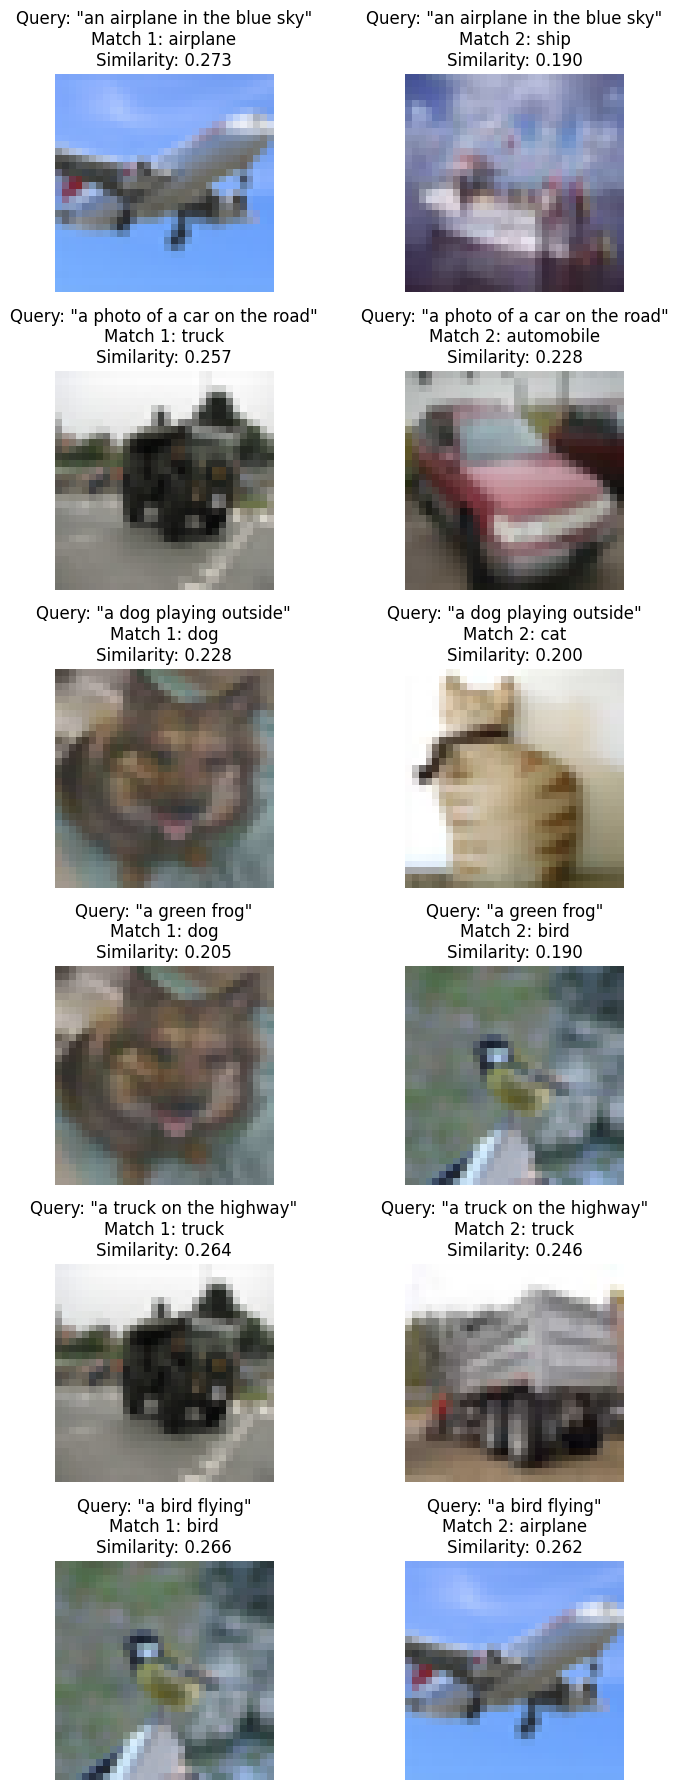


Similarity Matrix (Text Queries vs Images):
Rows: Text queries, Columns: Images


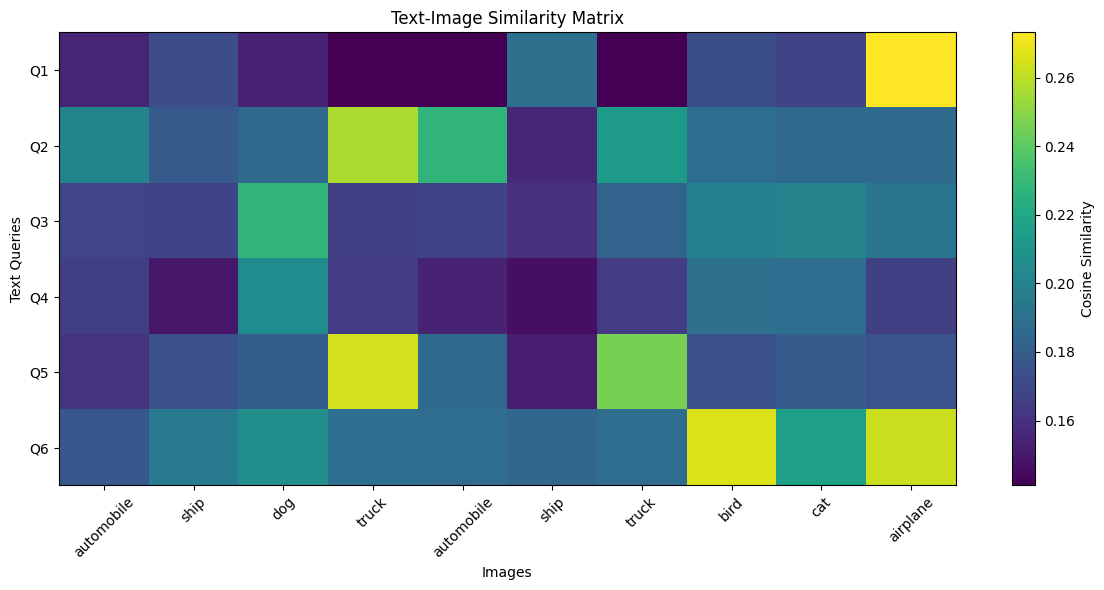

In [14]:
print("--- Step 5: Image-Text Retrieval ---\n")

# Set random seed for reproducible randomness (you can change this or remove for true randomness)
import random
random.seed(42)  # Remove this line for different results each run
np.random.seed(42)  # Remove this line for different results each run

# Select 10 diverse images randomly from different parts of the dataset
num_images = 10
total_images = len(cifar10)
# Create random indices ensuring diversity across the dataset
random_indices = sorted(np.random.choice(total_images, num_images, replace=False))
print(f"Selected image indices: {random_indices}")

retrieval_images_pil = [cifar10[i][0] for i in random_indices]
retrieval_images_labels = [cifar10.classes[cifar10[i][1]] for i in random_indices]
retrieval_images = torch.stack([clip_preprocess(img) for img in retrieval_images_pil]).to(device)

# Define text queries with some variety
base_queries = [
    "a photo of a car on the road",
    "an airplane in the blue sky", 
    "a cute cat sitting",
    "a picture of a horse",
    "a dog playing outside",
    "a bird flying",
    "a truck on the highway",
    "a ship sailing on water",
    "a deer in the forest",
    "a green frog"
]

# Randomly select queries to match number of CIFAR-10 classes or use a subset
num_queries = min(len(base_queries), 6)  # Use 6 queries for better visualization
selected_queries = random.sample(base_queries, num_queries)
text_queries = selected_queries
print(f"Selected queries: {text_queries}")

query_inputs = clip.tokenize(text_queries).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(retrieval_images)
    text_features = clip_model.encode_text(query_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Text -> Image Retrieval
print("Text-to-Image Retrieval:")
similarity = text_features @ image_features.T
best_image_indices = similarity.argmax(dim=1)

# Show top 2 matches for each query for more interesting results
top_k = 2
top_image_indices = similarity.topk(top_k, dim=1)[1]

fig, axes = plt.subplots(len(text_queries), top_k, figsize=(8, len(text_queries) * 3))
if len(text_queries) == 1:
    axes = axes.reshape(1, -1)

for i, query in enumerate(text_queries):
    for j in range(top_k):
        retrieved_idx = top_image_indices[i, j].item()
        img = retrieval_images_pil[retrieved_idx]
        similarity_score = similarity[i, retrieved_idx].item()
        
        ax = axes[i, j]
        ax.imshow(img)
        ax.set_title(f"Query: \"{query}\"\nMatch {j+1}: {retrieval_images_labels[retrieved_idx]}\nSimilarity: {similarity_score:.3f}")
        ax.axis('off')

plt.tight_layout()
plt.show()

# Additional analysis: Show similarity matrix
print("\nSimilarity Matrix (Text Queries vs Images):")
print("Rows: Text queries, Columns: Images")
sim_matrix = similarity.cpu().numpy()
plt.figure(figsize=(12, 6))
plt.imshow(sim_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Images')
plt.ylabel('Text Queries') 
plt.title('Text-Image Similarity Matrix')
plt.yticks(range(len(text_queries)), [f"Q{i+1}" for i in range(len(text_queries))])
plt.xticks(range(len(retrieval_images_labels)), retrieval_images_labels, rotation=45)
plt.tight_layout()
plt.show()

### 6. Representation Visualization (t-SNE)  

We compare the representation spaces of CLIP and ResNet-50 to analyze how each organizes data.  

- **Setup**:  
  - Extract embeddings for CIFAR-10 test images.  
  - Include both **photos** and **sketches**.  
  - Use **t-SNE** for dimensionality reduction.  

- **Process**:  
  1. Encode all images with CLIP and ResNet-50.  
  2. Project embeddings to 2D using t-SNE.  
  3. Plot clusters, colored by class and style (photo vs. sketch).  

- **Goal**:  
  - Observe whether embeddings cluster by **class** or by **style**.  
  - Compare semantic structure between CLIP and ResNet.  

Visualization reveals CLIP clusters by **semantic class** across domains, while ResNet tends to separate images by style (photo vs. sketch), showing its reliance on superficial features.


--- Step 6: Representation Visualization (t-SNE) ---

Randomly selected 50 samples for visualization
Class distribution: ['deer', 'frog', 'airplane', 'horse', 'horse', 'deer', 'deer', 'truck', 'dog', 'ship']...


Generating Embeddings: 100%|██████████| 50/50 [00:01<00:00, 34.81it/s]



Using t-SNE parameters: perplexity=22, learning_rate=139


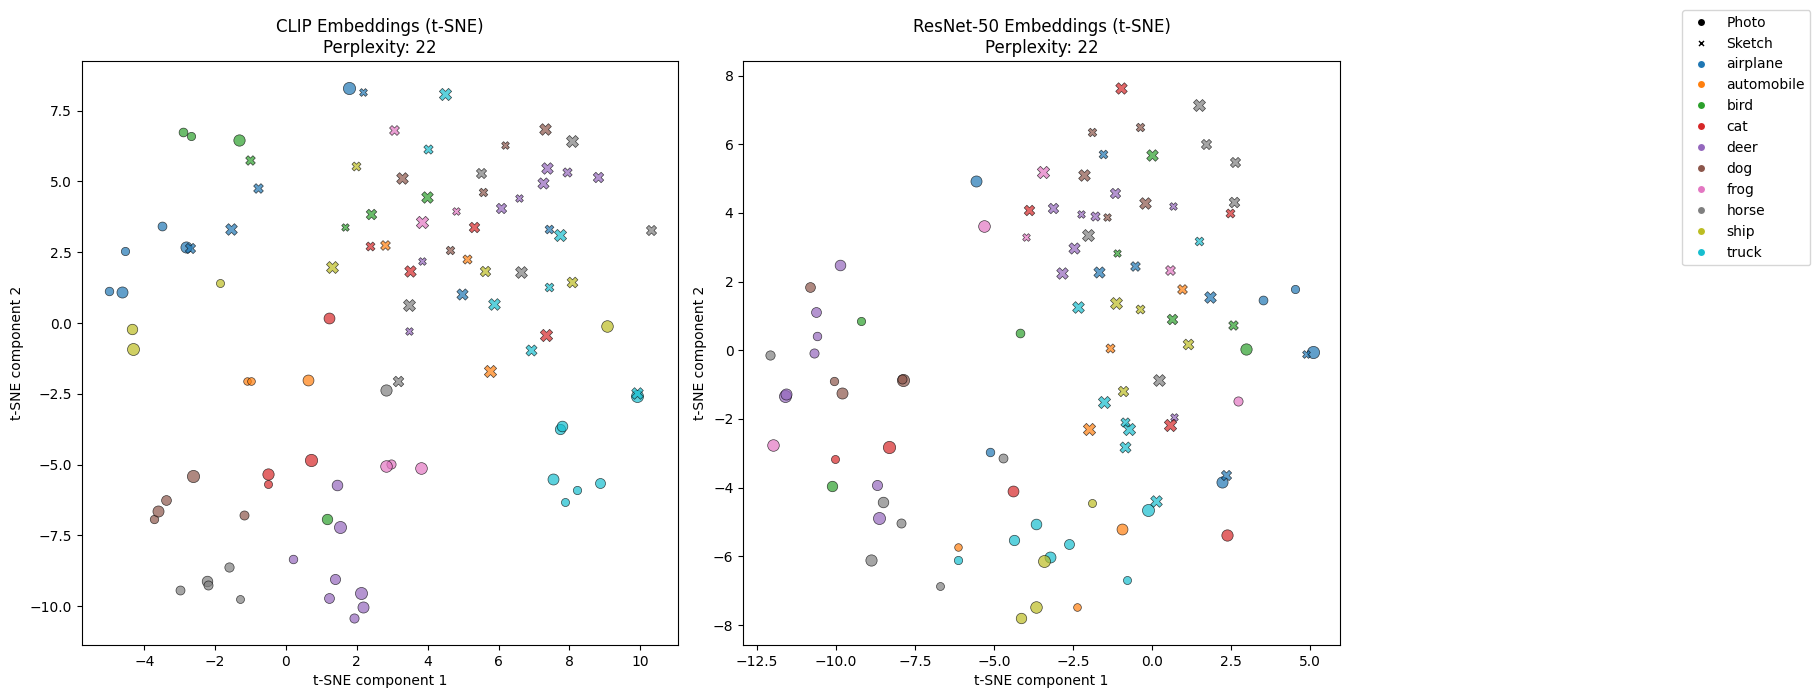

t-SNE plots saved as tsne_comparison.png
Analysis: CLIP clusters images by semantic class (e.g., all cats together) regardless of domain (photo vs sketch).
ResNet clusters primarily by domain, showing it relies on superficial features like texture and style.
Note: This run used 50 random samples with t-SNE perplexity=22




In [ ]:
print("--- Step 6: Representation Visualization (t-SNE) ---\n")

# Add randomization to sample selection
import random
random.seed(None)  # Use current time for true randomness
np.random.seed(None)  # Use current time for true randomness

# Collect a mix of photos and sketches with random sampling
num_viz_samples = 50
total_samples = len(cifar10)

# Randomly sample indices ensuring we get diverse classes
random_indices = np.random.choice(total_samples, num_viz_samples, replace=False)
photo_samples = [cifar10[i] for i in random_indices]
sketch_samples = [(create_sketch(img), label) for img, label in photo_samples]

print(f"Randomly selected {num_viz_samples} samples for visualization")
print(f"Class distribution: {[cifar10.classes[label] for _, label in photo_samples[:10]]}...")  # Show first 10

clip_embeddings = []
resnet_embeddings = []
labels = []
domains = [] # 0 for photo, 1 for sketch

# Hook to get ResNet features before the final layer
def get_resnet_features(model):
    features = None
    def hook(mod, inp, out):
        nonlocal features
        features = out.view(out.size(0), -1)
    handle = model.avgpool.register_forward_hook(hook)
    return hook, lambda: features, handle

hook, get_features, handle = get_resnet_features(resnet_model)

for (img, label), (sketch, _) in tqdm(zip(photo_samples, sketch_samples), total=num_viz_samples, desc="Generating Embeddings"):
    # Photos
    with torch.no_grad():
        clip_img_in = clip_preprocess(img).unsqueeze(0).to(device)
        clip_embeddings.append(clip_model.encode_image(clip_img_in).cpu().numpy().flatten())
        
        res_img_in = resnet_preprocess(img).unsqueeze(0).to(device)
        _ = resnet_model(res_img_in)
        resnet_embeddings.append(get_features().cpu().numpy().flatten())

    labels.append(label)
    domains.append(0)

    # Sketches
    with torch.no_grad():
        clip_sketch_in = clip_preprocess(sketch).unsqueeze(0).to(device)
        clip_embeddings.append(clip_model.encode_image(clip_sketch_in).cpu().numpy().flatten())
        
        res_sketch_in = resnet_preprocess(sketch).unsqueeze(0).to(device)
        _ = resnet_model(res_sketch_in)
        resnet_embeddings.append(get_features().cpu().numpy().flatten())
    
    labels.append(label)
    domains.append(1)

handle.remove() # Clean up the hook

# Reduce dimensionality with t-SNE (with randomized parameters)
perplexity = np.random.randint(10, 30)  # Random perplexity between 10-30
learning_rate = np.random.randint(100, 300)  # Random learning rate
print(f"Using t-SNE parameters: perplexity={perplexity}, learning_rate={learning_rate}")

tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=None)
clip_2d = tsne.fit_transform(np.array(clip_embeddings))

tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=None)
resnet_2d = tsne.fit_transform(np.array(resnet_embeddings))

# Plotting with enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
markers = ['o', 'X'] # o for photo, X for sketch
colors = plt.cm.get_cmap("tab10", 10)

# Plot with varying sizes for better visualization
for i in range(len(labels)):
    size = np.random.randint(30, 80)  # Random marker sizes for variety
    # CLIP Plot
    ax1.scatter(clip_2d[i, 0], clip_2d[i, 1],
                color=colors(labels[i]),
                marker=markers[domains[i]],
                s=size,
                alpha=0.7,
                edgecolors='black',
                linewidth=0.5)
    # ResNet Plot
    ax2.scatter(resnet_2d[i, 0], resnet_2d[i, 1],
                color=colors(labels[i]),
                marker=markers[domains[i]],
                s=size,
                alpha=0.7,
                edgecolors='black',
                linewidth=0.5)

ax1.set_title(f"CLIP Embeddings (t-SNE)\nPerplexity: {perplexity}")
ax2.set_title(f"ResNet-50 Embeddings (t-SNE)\nPerplexity: {perplexity}")
ax1.set_xlabel("t-SNE component 1")
ax1.set_ylabel("t-SNE component 2")
ax2.set_xlabel("t-SNE component 1")
ax2.set_ylabel("t-SNE component 2")

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=markers[0], color='w', label='Photo', markerfacecolor='k'),
                   Line2D([0], [0], marker=markers[1], color='w', label='Sketch', markerfacecolor='k')]
for i, name in enumerate(cifar10_classes):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=name, markerfacecolor=colors(i)))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

print("t-SNE plots saved as tsne_comparison.png")
print("Analysis: CLIP clusters images by semantic class (e.g., all cats together) regardless of domain (photo vs sketch).")
print("ResNet clusters primarily by domain, showing it relies on superficial features like texture and style.")
print(f"Note: This run used {num_viz_samples} random samples with t-SNE perplexity={perplexity}")

### 7. Shape vs. Texture Bias  

We investigate differences in how models perceive objects — whether by **shape** or by **texture**.  

- **Setup**:  
  - Create “cue conflict” images (e.g., cat-shaped object with elephant skin).  
  - Define prompts such as:  
    - `"a cat"`  
    - `"an elephant"`.  

- **Process**:  
  1. Encode ambiguous images with CLIP and ResNet.  
  2. Compare which label each model predicts.  

- **Goal**:  
  - Determine if CLIP is **shape-biased** (identifies cat by outline).  
  - Determine if ResNet is **texture-biased** (predicts elephant due to texture).  

Findings highlight CLIP’s **semantic shape bias**, contrasting with CNNs like ResNet that over-rely on textures.


--- Step 7: Shape vs. Texture Bias Test ---

--- Analysis of the Cue-Conflict Image ---


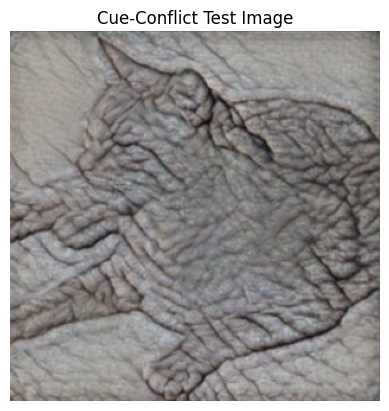


CLIP Model Prediction:
  Similarity with 'a photo of a cat': 0.0379
  Similarity with 'a photo of an elephant': 0.9619
--> Result: CLIP is TEXTURE-BIASED, misidentifying the 'elephant'.

ResNet-50 Baseline Prediction:
  The model (trained on CIFAR-10) predicted: 'horse'
--> Result: ResNet is likely TEXTURE-BIASED. It ignored the cat's shape and was confused by the unfamiliar skin texture, predicting another animal.


In [ ]:
print("--- Step 7: Shape vs. Texture Bias Test ---")

try:
    # Load the cue-conflict image (cat shape, elephant texture), as RGB since our preporcess has 3 dim input
    cue_conflict_image = Image.open("cue_conflict.png").convert("RGB")
    
    # Define the competing text prompts
    shape_prompt = "a photo of a cat"
    texture_prompt = "a photo of an elephant"
    text_inputs = clip.tokenize([shape_prompt, texture_prompt]).to(device)

    # Preprocess the image for both models
    clip_image_input = clip_preprocess(cue_conflict_image).unsqueeze(0).to(device)
    resnet_image_input = resnet_preprocess(cue_conflict_image).unsqueeze(0).to(device)

    # --- Test CLIP ---
    with torch.no_grad():
        image_features = clip_model.encode_image(clip_image_input)
        text_features = clip_model.encode_text(text_inputs)
        
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity scores
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        shape_score = similarity[0, 0].item()
        texture_score = similarity[0, 1].item()

    # --- Test ResNet-50 Baseline ---
    with torch.no_grad():
        output = resnet_model(resnet_image_input)
        resnet_prediction_idx = output.argmax().item()
        # The ResNet model is trained on CIFAR-10, so it will predict one of those classes.
        resnet_prediction_name = cifar10_classes[resnet_prediction_idx]

    # --- Analysis and Visualization ---
    print("\n--- Analysis of the Cue-Conflict Image ---")
    
    plt.imshow(cue_conflict_image)
    plt.title("Cue-Conflict Test Image")
    plt.axis('off')
    plt.show()

    print("\nCLIP Model Prediction:")
    print(f"  Similarity with '{shape_prompt}': {shape_score:.4f}")
    print(f"  Similarity with '{texture_prompt}': {texture_score:.4f}")
    if shape_score > texture_score:
        print("--> Result: CLIP is SHAPE-BIASED, correctly identifying the 'cat'.")
    else:
        print("--> Result: CLIP is TEXTURE-BIASED, misidentifying the 'elephant'.")

    print("\nResNet-50 Baseline Prediction:")
    print(f"  The model (trained on CIFAR-10) predicted: '{resnet_prediction_name}'")
    if resnet_prediction_name.lower() in ["dog", "bird", "horse", "deer"]:
        print("--> Result: ResNet is likely TEXTURE-BIASED. It ignored the cat's shape and was confused by the unfamiliar skin texture, predicting another animal.")
    else:
        print("--> Result: ResNet's prediction is not clearly shape or texture-based, but it failed to identify the cat's shape.")
        
except FileNotFoundError:
    print("ERROR: 'cue_conflict.png' not found. Please download the cat-elephant \"Geirhos cat elephant\" cue-conflict image to run this test.")

### 8. Robustness to Corruptions  

We test how well models handle **corrupted inputs**, such as noise, blur, or grayscale transformations.  

- **Setup**:  
  - Apply common corruptions (Gaussian noise, blur, grayscale) to CIFAR-10 images.  
  - Use the same CLIP and ResNet pipelines.  

- **Process**:  
  1. Encode corrupted images with both models.  
  2. Evaluate classification accuracy and qualitative predictions.  

- **Goal**:  
  - Compare robustness of CLIP vs. ResNet under perturbations.  
  - Assess whether semantic generalization helps CLIP resist corruptions.  

CLIP generally maintains correct predictions under corruption, while ResNet’s accuracy degrades quickly — showcasing CLIP’s robustness from training on diverse, noisy data.

--- Step 8: Robustness Test ---

Testing with random image #7356: airplane
Using noise variance: 0.056, blur sigma: 1.50
Testing robustness on an image of a 'airplane'.

Image Type           | CLIP Prediction      | Baseline Prediction  | Confidence
-------------------------------------------------------------------------------------
Original             | airplane             | automobile           | 0.712
Gaussian Noise       | airplane             | automobile           | 0.865
Blurred              | airplane             | automobile           | 0.558
Grayscale            | airplane             | automobile           | 0.806
Salt & Pepper        | airplane             | automobile           | 0.669
Brightness×0.56      | airplane             | automobile           | 0.696
Salt & Pepper        | airplane             | automobile           | 0.669
Brightness×0.56      | airplane             | automobile           | 0.696


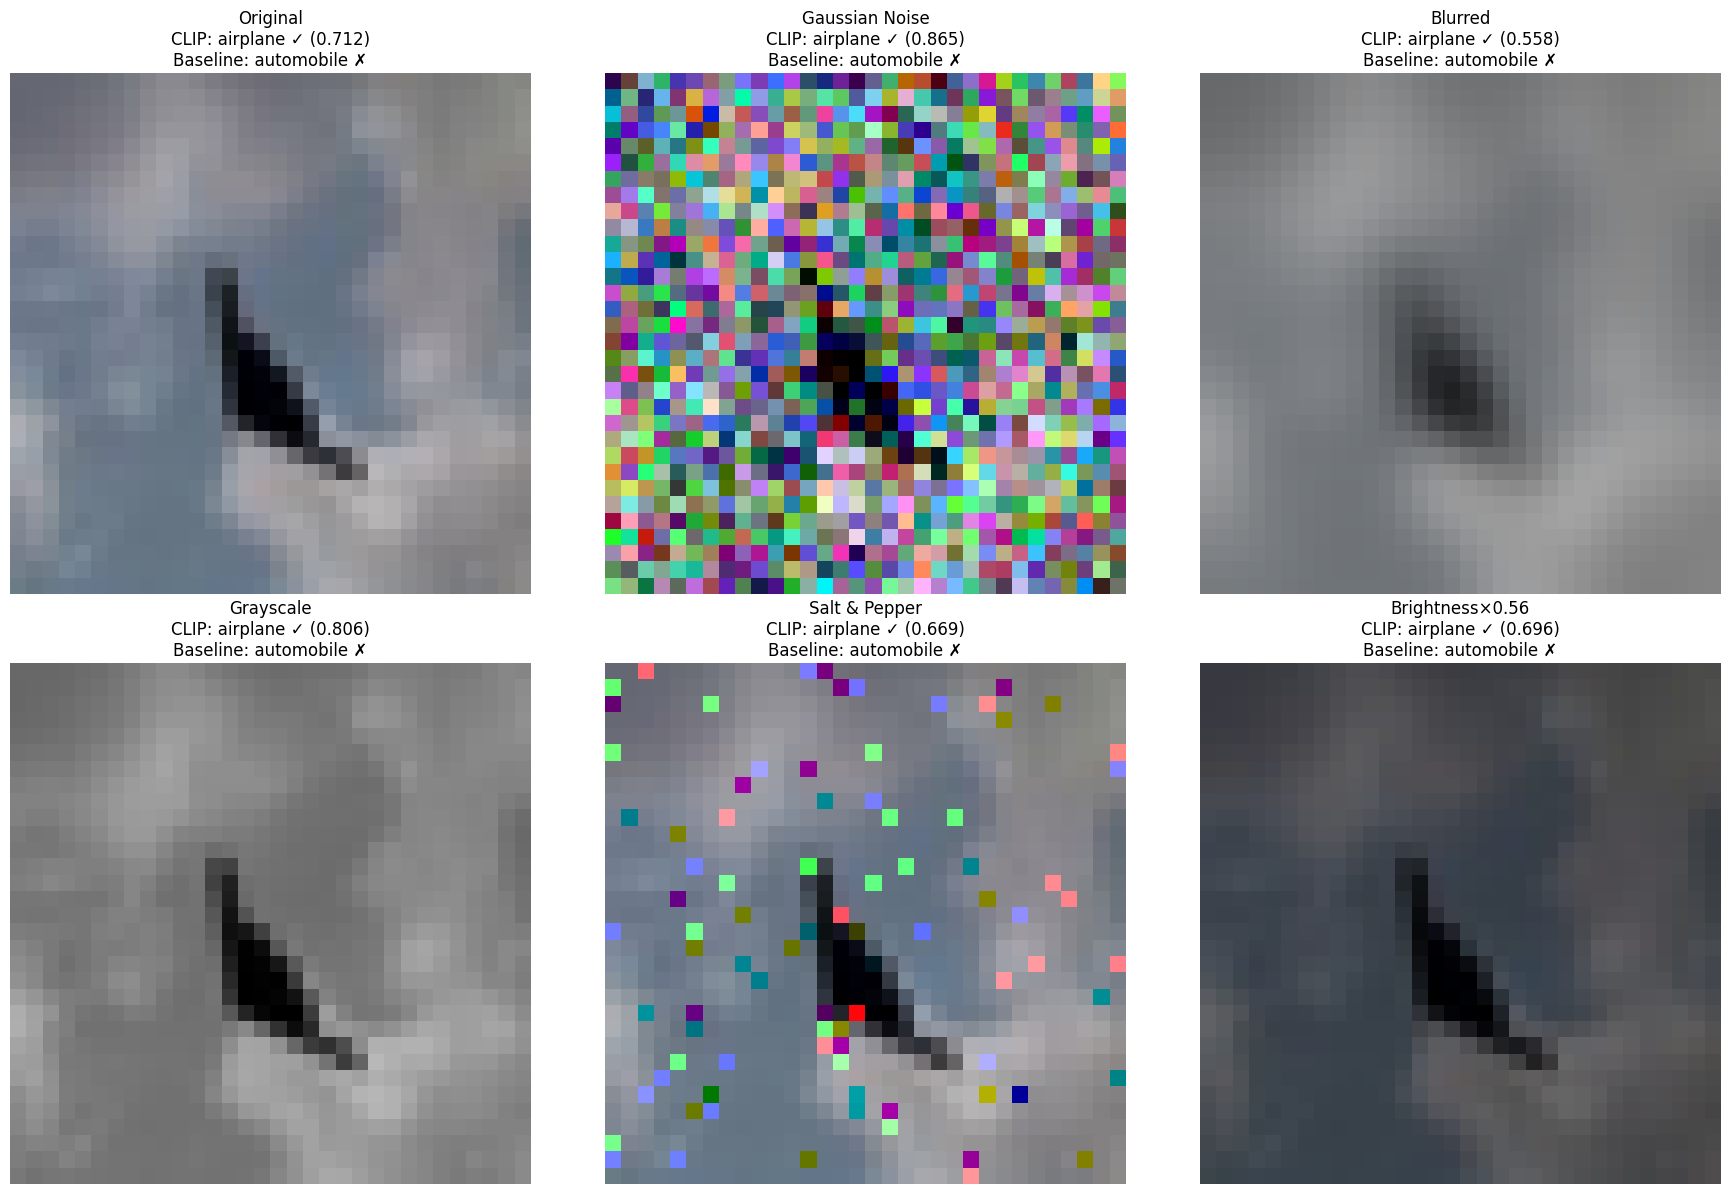

This test used random corruption parameters: noise_var=0.056, blur_sigma=1.50


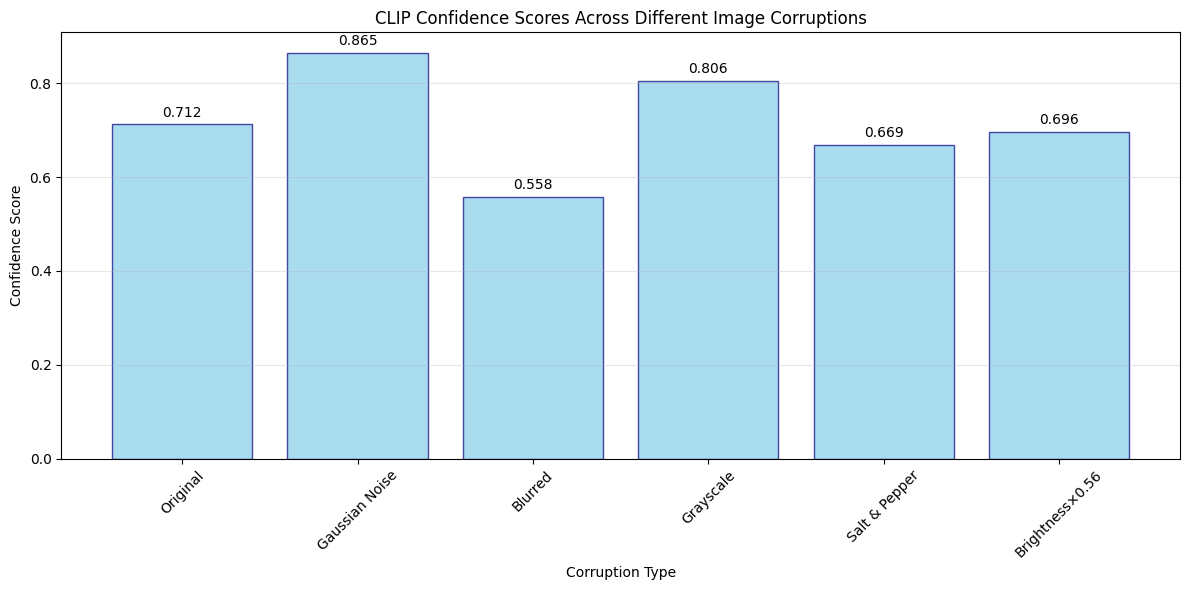

In [17]:
print("--- Step 8: Robustness Test ---\n")

# Randomly select a sample image instead of always using cat
random_idx = np.random.randint(0, len(cifar10))
sample_img_pil, sample_label = cifar10[random_idx]
sample_label_name = cifar10.classes[sample_label]
print(f"Testing with random image #{random_idx}: {sample_label_name}")

# Apply corruptions with randomized parameters
img_array = np.array(sample_img_pil)

# Randomize corruption parameters for variety
noise_var = np.random.uniform(0.02, 0.08)  # Random noise variance
blur_sigma = np.random.uniform(1.0, 2.5)   # Random blur strength
print(f"Using noise variance: {noise_var:.3f}, blur sigma: {blur_sigma:.2f}")

noisy_img = Image.fromarray((random_noise(img_array, mode='gaussian', var=noise_var) * 255).astype(np.uint8))
blurred_img = Image.fromarray(gaussian_filter(img_array, sigma=blur_sigma).astype(np.uint8))
grayscale_img = sample_img_pil.convert("L").convert("RGB")

# Add additional corruption types for more variety
def add_pepper_salt_noise(image, amount=0.05):
    """Add salt and pepper noise"""
    img_array = np.array(image)
    noisy = random_noise(img_array, mode='s&p', amount=amount)
    return Image.fromarray((noisy * 255).astype(np.uint8))

def adjust_brightness(image, factor=None):
    """Adjust brightness randomly"""
    if factor is None:
        factor = np.random.uniform(0.3, 1.8)  # Random brightness factor
    img_array = np.array(image).astype(np.float32)
    bright_img = np.clip(img_array * factor, 0, 255).astype(np.uint8)
    return Image.fromarray(bright_img)

salt_pepper_img = add_pepper_salt_noise(sample_img_pil, amount=np.random.uniform(0.02, 0.08))
brightness_factor = np.random.uniform(0.4, 1.7)
bright_img = adjust_brightness(sample_img_pil, brightness_factor)

images_to_test = {
    "Original": sample_img_pil,
    "Gaussian Noise": noisy_img,
    "Blurred": blurred_img,
    "Grayscale": grayscale_img,
    "Salt & Pepper": salt_pepper_img,
    f"Brightness×{brightness_factor:.2f}": bright_img
}

print(f"Testing robustness on an image of a '{sample_label_name}'.\n")
print(f"{'Image Type':<20} | {'CLIP Prediction':<20} | {'Baseline Prediction':<20} | {'Confidence'}")
print("-" * 85)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, img) in enumerate(images_to_test.items()):
    # CLIP Prediction
    with torch.no_grad():
        image_input = clip_preprocess(img).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        clip_pred_idx = similarity.argmax().item()
        clip_pred_name = cifar10_classes[clip_pred_idx]
        confidence = similarity.max().item()

        resnet_pred_name = "N/A"
        if resnet_model:
            image_input_resnet = resnet_preprocess(img).unsqueeze(0).to(device)
            output = resnet_model(image_input_resnet)
            resnet_pred_name = cifar10_classes[output.argmax().item()]

    print(f"{name:<20} | {clip_pred_name:<20} | {resnet_pred_name:<20} | {confidence:.3f}")

    ax = axes[i]
    ax.imshow(img)
    correctness_clip = "✓" if clip_pred_name == sample_label_name else "✗"
    correctness_resnet = "✓" if resnet_pred_name == sample_label_name else "✗"
    ax.set_title(f"{name}\nCLIP: {clip_pred_name} {correctness_clip} ({confidence:.3f})\nBaseline: {resnet_pred_name} {correctness_resnet}")
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"This test used random corruption parameters: noise_var={noise_var:.3f}, blur_sigma={blur_sigma:.2f}")

# Additional: Show confidence scores across corruptions
corruption_names = list(images_to_test.keys())
clip_confidences = []
for name, img in images_to_test.items():
    with torch.no_grad():
        image_input = clip_preprocess(img).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        confidence = similarity.max().item()
        clip_confidences.append(confidence)

plt.figure(figsize=(12, 6))
bars = plt.bar(corruption_names, clip_confidences, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('CLIP Confidence Scores Across Different Image Corruptions')
plt.xlabel('Corruption Type')
plt.ylabel('Confidence Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, conf in zip(bars, clip_confidences):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{conf:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()